# Lab 1: Deep Neural Network

## Author: Dallas Hutchinson

##### in collaboration with: Sam Hickey

## Problem 1:

### Approximate the following function:
$\Large f ( x ) = 3x^2 + 4x - 9 $


### Steps:
1. Randomly generate the data. Generate at least 10,000 values for $x \in [-100,100]$
2. Plot the function
3. Design a feed-forward network with 2 or more hidden layers. Choose the # of hidden units in each layer (what are the size of input and output layers?)
4. Train the model (What loss function will be suitable here?)
5. Generate a test data and present the test accuracy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


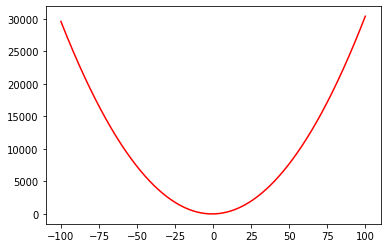

In [2]:
# 1. Randomly generate 10,000 data points for 𝑥 ∈ [−100,100]
def f(x):
    return (3*(x**2)) + (4*x) - 9

train_x = torch.FloatTensor(10000).uniform_(-100, 101)
train_y = torch.FloatTensor([f(x) for x in train_x])
train_dataloader = DataLoader(
    TensorDataset(train_x.unsqueeze(1), train_y.unsqueeze(1)),
    batch_size=100,
    pin_memory=True,
    shuffle=True
)

test_x = torch.FloatTensor(5000).uniform_(-100, 101)
test_y = torch.FloatTensor([f(x) for x in test_x])
test_dataloader = DataLoader(
    TensorDataset(test_x.unsqueeze(1), test_y.unsqueeze(1)),
    batch_size=100,
    pin_memory=True,
    shuffle=True
)

# 2. Plot the function

x = np.linspace(-100, 100, 10000)
plt.plot(x, f(x), 'r')
plt.show()

In [3]:
# 3. Design a feed-forward network with 2 or more hidden layers. Choose the # of hidden units in each layer (what are the size of input and output layers?)

num_epochs = 25
batch_size = 512
learning_rate = 0.005
hidden_size = 64

model = nn.Sequential(nn.Linear(1, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, 1))

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 4. Train the model (What loss function will be suitable here?)
# RMSE loss function will be suitable due to the continuous nature of the data

train_loss_list = list()
val_loss_list = list()
for epoch in range(num_epochs):
    print("epoch %d / %d" % (epoch+1, num_epochs))
    model.train()
    
    # training loop
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32)
        y_train = y_train.type(torch.float32)

        optimizer.zero_grad()

        score = model(X_train)
        loss = torch.sqrt(criterion(input=score, target=y_train))
        loss.backward()

        optimizer.step()

        temp_loss_list.append(loss.detach().numpy())
        
    train_loss_list.append(np.average(temp_loss_list))
    
# 5. Generate a test data and present the test accuracy

    model.eval()
    
    temp_loss_list = list()
    for X_val, y_val in test_dataloader:
        X_val = X_val.type(torch.float32)
        y_val = y_val.type(torch.float32)

        score = model(X_val)
        loss = torch.sqrt(criterion(input=score, target=y_val))

        temp_loss_list.append(loss.detach().numpy())
    
    val_loss_list.append(np.average(temp_loss_list))

    print("\ttrain loss: %.5f" % train_loss_list[-1])
    print("\tval loss: %.5f" % val_loss_list[-1])

epoch 1 / 25
	train loss: 6329.11621
	val loss: 3375.54932
epoch 2 / 25
	train loss: 3382.80005
	val loss: 3327.96069
epoch 3 / 25
	train loss: 3318.50439
	val loss: 3246.96118
epoch 4 / 25
	train loss: 3244.31934
	val loss: 3170.93848
epoch 5 / 25
	train loss: 3158.00366
	val loss: 3079.92310
epoch 6 / 25
	train loss: 3024.71338
	val loss: 2907.08667
epoch 7 / 25
	train loss: 2805.51245
	val loss: 2601.75879
epoch 8 / 25
	train loss: 2374.80640
	val loss: 1960.87610
epoch 9 / 25
	train loss: 1367.96924
	val loss: 855.70642
epoch 10 / 25
	train loss: 510.19284
	val loss: 512.31665
epoch 11 / 25
	train loss: 363.16367
	val loss: 144.42563
epoch 12 / 25
	train loss: 237.38136
	val loss: 398.18616
epoch 13 / 25
	train loss: 230.75969
	val loss: 216.98373
epoch 14 / 25
	train loss: 199.98764
	val loss: 105.43235
epoch 15 / 25
	train loss: 174.61516
	val loss: 113.73731
epoch 16 / 25
	train loss: 159.19525
	val loss: 482.95959
epoch 17 / 25
	train loss: 140.55940
	val loss: 101.02122
epoch 

### Here we can see training and test loss decreasing as epochs increase. More epochs would most likely lead to lower loss.

## Problem 2:

### Feedforward Network
- Hidden layer 1
- Input size 784 [28X28] image
- Hidden layer units 500
- Output size 10
- Other Hyperparameters:
 - num_epochs = 5
 - batch_size = 100
 - learning_rate = 0.001

### Try out different regularization and optimization techniques and vary the corresponding hyperparameters
- Hidden layers/units per layer
- L2 regularization
- Dropout
- RMSProp
- Adam
- Minibatches

### Tabulate your findings

In [4]:
import torchvision
import torchvision.transforms as transforms
from ipywidgets import FloatProgress

In [5]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

### Defining the network

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        ## nn.BatchNorm1d(hidden_size) ## [Optional batch normalization]
        ## nn.Dropout(0.2) ## [Optional dropout]
        #self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.output = nn.Softmax(dim=1)  # nn.Linear if y is real-valued
        self.float()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

### Loading the datasets

<i> 
#### Note: If the following code does not work, do the following:
- open a terminal and enter
- pip install ipywidgets
- jupyter nbextension enable --py widgetsnbextension

#### If the second line shows [OK], it should work </i>

In [7]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=False, 
                                           transform=transforms.ToTensor(),download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, shuffle=True)

##### Display samples

4


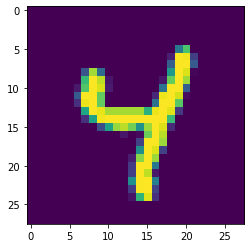

In [9]:
import matplotlib.pyplot as plt

for images, labels in train_loader:
    print(labels[0].item())
 
    plt.imshow(images[0].reshape((28,28)))
    break

In [10]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [11]:
for parameter in model.parameters():
    print(parameter.shape)
    print(parameter.requires_grad)

torch.Size([500, 784])
True
torch.Size([500])
True
torch.Size([10, 500])
True
torch.Size([10])
True


In [12]:
#criterion = nn.NLLLoss() # another loss function to test
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

### Train the model

In [13]:
total_step = len(train_loader)
loss_history = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Reconfigure the images into a 1D vector (actually, (X,1) tensor)
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        ### Comput the output and loss
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Append to loss history
        loss_history.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # display the progress
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        

Epoch [1/5], Step [100/600], Loss: 1.5696
Epoch [1/5], Step [200/600], Loss: 1.5611
Epoch [1/5], Step [300/600], Loss: 1.5903
Epoch [1/5], Step [400/600], Loss: 1.5690
Epoch [1/5], Step [500/600], Loss: 1.5219
Epoch [1/5], Step [600/600], Loss: 1.6052
Epoch [2/5], Step [100/600], Loss: 1.5185
Epoch [2/5], Step [200/600], Loss: 1.5180
Epoch [2/5], Step [300/600], Loss: 1.5208
Epoch [2/5], Step [400/600], Loss: 1.4807
Epoch [2/5], Step [500/600], Loss: 1.4644
Epoch [2/5], Step [600/600], Loss: 1.5214
Epoch [3/5], Step [100/600], Loss: 1.5146
Epoch [3/5], Step [200/600], Loss: 1.5089
Epoch [3/5], Step [300/600], Loss: 1.4886
Epoch [3/5], Step [400/600], Loss: 1.5243
Epoch [3/5], Step [500/600], Loss: 1.5306
Epoch [3/5], Step [600/600], Loss: 1.4624
Epoch [4/5], Step [100/600], Loss: 1.4886
Epoch [4/5], Step [200/600], Loss: 1.4704
Epoch [4/5], Step [300/600], Loss: 1.5143
Epoch [4/5], Step [400/600], Loss: 1.4776
Epoch [4/5], Step [500/600], Loss: 1.4891
Epoch [4/5], Step [600/600], Loss:

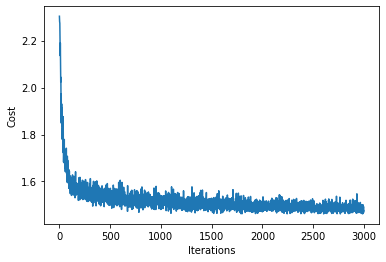

In [14]:
plt.plot(loss_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

In [15]:
correct_count, all_count = 0, 0
for images, labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # with torch.no_grad():
    ps = model(img)

    
    # ps = torch.exp(logps)
    probab = list(ps.detach().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("Model Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000
Model Accuracy = 0.9721


#### Taking 4 samples from the test set 
- display the image
- print the true label
- print the output probability distribution
- print the predicted class

In [16]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 4
True Digit = 4
Predicted Digit = 7
True Digit = 7
Predicted Digit = 9
True Digit = 9
Predicted Digit = 3
True Digit = 3


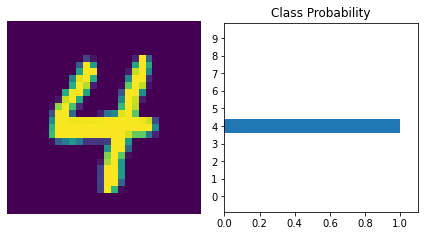

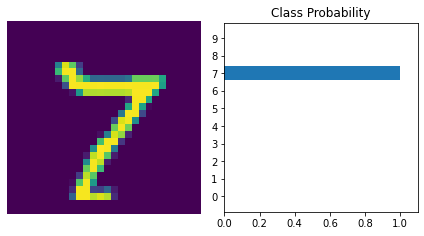

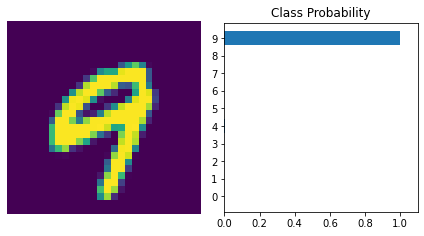

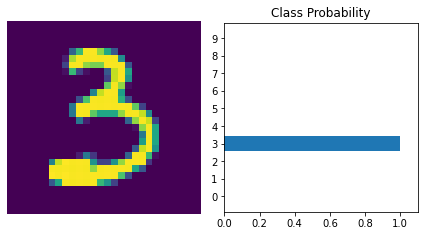

In [17]:
for sample in range(4):
    # Separate images and labels from validation set
    images, labels = next(iter(test_loader))

    # Flatten the 28x28 image
    img = images[sample].view(1, 784)
    
    # Get probability for each class by putting img through the model
    ps = model(img)

    probab = list(ps.detach().numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    print("True Digit =", int(labels[sample]))
    view_classify(img.view(1, 28, 28), ps)

In [18]:
# Testing out different hyperparameter values
# Dropout rate

input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Dropout(0.7),
                      nn.Linear(hidden_size, num_classes),
                      nn.Softmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

total_step = len(train_loader)
loss_history = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Reconfigure the images into a 1D vector (actually, (X,1) tensor)
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        ### Comput the output and loss
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Append to loss history
        loss_history.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # display the progress
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 1.6541
Epoch [1/5], Step [200/600], Loss: 1.5990
Epoch [1/5], Step [300/600], Loss: 1.5690
Epoch [1/5], Step [400/600], Loss: 1.6025
Epoch [1/5], Step [500/600], Loss: 1.5502
Epoch [1/5], Step [600/600], Loss: 1.5848
Epoch [2/5], Step [100/600], Loss: 1.5276
Epoch [2/5], Step [200/600], Loss: 1.5603
Epoch [2/5], Step [300/600], Loss: 1.5227
Epoch [2/5], Step [400/600], Loss: 1.5135
Epoch [2/5], Step [500/600], Loss: 1.5799
Epoch [2/5], Step [600/600], Loss: 1.5712
Epoch [3/5], Step [100/600], Loss: 1.5350
Epoch [3/5], Step [200/600], Loss: 1.5328
Epoch [3/5], Step [300/600], Loss: 1.5683
Epoch [3/5], Step [400/600], Loss: 1.5443
Epoch [3/5], Step [500/600], Loss: 1.5252
Epoch [3/5], Step [600/600], Loss: 1.5442
Epoch [4/5], Step [100/600], Loss: 1.5083
Epoch [4/5], Step [200/600], Loss: 1.5223
Epoch [4/5], Step [300/600], Loss: 1.5308
Epoch [4/5], Step [400/600], Loss: 1.5279
Epoch [4/5], Step [500/600], Loss: 1.5270
Epoch [4/5], Step [600/600], Loss:

### Varying the dropout rate from 0 to 1 did not lead to much of a decrease in loss.

In [19]:
# Testing out different hyperparameter values
# Switched optimizer to SGD and added momentum to speed up our loss reduction

input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, num_classes),
                      nn.Softmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 

total_step = len(train_loader)
loss_history = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Reconfigure the images into a 1D vector (actually, (X,1) tensor)
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        ### Comput the output and loss
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Append to loss history
        loss_history.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # display the progress
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 2.2997
Epoch [1/5], Step [200/600], Loss: 2.2994
Epoch [1/5], Step [300/600], Loss: 2.2912
Epoch [1/5], Step [400/600], Loss: 2.2920
Epoch [1/5], Step [500/600], Loss: 2.2868
Epoch [1/5], Step [600/600], Loss: 2.2775
Epoch [2/5], Step [100/600], Loss: 2.2597
Epoch [2/5], Step [200/600], Loss: 2.2658
Epoch [2/5], Step [300/600], Loss: 2.2569
Epoch [2/5], Step [400/600], Loss: 2.2455
Epoch [2/5], Step [500/600], Loss: 2.2254
Epoch [2/5], Step [600/600], Loss: 2.2360
Epoch [3/5], Step [100/600], Loss: 2.2106
Epoch [3/5], Step [200/600], Loss: 2.1490
Epoch [3/5], Step [300/600], Loss: 2.1646
Epoch [3/5], Step [400/600], Loss: 2.1577
Epoch [3/5], Step [500/600], Loss: 2.1184
Epoch [3/5], Step [600/600], Loss: 2.1058
Epoch [4/5], Step [100/600], Loss: 2.0955
Epoch [4/5], Step [200/600], Loss: 2.0410
Epoch [4/5], Step [300/600], Loss: 2.0276
Epoch [4/5], Step [400/600], Loss: 2.0242
Epoch [4/5], Step [500/600], Loss: 2.0319
Epoch [4/5], Step [600/600], Loss:

### Using SGD and momentum saw a decent decrease in loss. 2.3 -> 1.9

In [20]:
# Testing out different hyperparameter values
# Activation function changed to sigmoid, learning rate increased, adding L2 regularization

input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.003

model = nn.Sequential(nn.Linear(input_size, hidden_size),
                      nn.Sigmoid(),
                      nn.Linear(hidden_size, num_classes),
                      nn.Softmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001) 

total_step = len(train_loader)
loss_history = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Reconfigure the images into a 1D vector (actually, (X,1) tensor)
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        ### Comput the output and loss
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Append to loss history
        loss_history.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # display the progress
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 1.8183
Epoch [1/5], Step [200/600], Loss: 1.7800
Epoch [1/5], Step [300/600], Loss: 1.7592
Epoch [1/5], Step [400/600], Loss: 1.7095
Epoch [1/5], Step [500/600], Loss: 1.7627
Epoch [1/5], Step [600/600], Loss: 1.6701
Epoch [2/5], Step [100/600], Loss: 1.7160
Epoch [2/5], Step [200/600], Loss: 1.6600
Epoch [2/5], Step [300/600], Loss: 1.6075
Epoch [2/5], Step [400/600], Loss: 1.6216
Epoch [2/5], Step [500/600], Loss: 1.6007
Epoch [2/5], Step [600/600], Loss: 1.5930
Epoch [3/5], Step [100/600], Loss: 1.6016
Epoch [3/5], Step [200/600], Loss: 1.5832
Epoch [3/5], Step [300/600], Loss: 1.5943
Epoch [3/5], Step [400/600], Loss: 1.6216
Epoch [3/5], Step [500/600], Loss: 1.6159
Epoch [3/5], Step [600/600], Loss: 1.6168
Epoch [4/5], Step [100/600], Loss: 1.6102
Epoch [4/5], Step [200/600], Loss: 1.6670
Epoch [4/5], Step [300/600], Loss: 1.6243
Epoch [4/5], Step [400/600], Loss: 1.6296
Epoch [4/5], Step [500/600], Loss: 1.6092
Epoch [4/5], Step [600/600], Loss:

### Using a higher learning rate and L2 regulartization led to an initial improved loss and slight decrease over each epoch. There does seem to be some loss oscillation happening as it increases and decreases